In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#read data
dataset = pd.read_csv('/Users/zkl/Desktop/5291/project/Data_clear.csv')
dataset_valid = dataset.dropna(thresh=1050, axis=1)
dataset_valid = dataset_valid.dropna(axis=0)

#add patient_id and visit_month variables to the dataset
patient_month = dataset_valid['visit_id'].str.split('_', expand=True)
dataset_valid['patient_id'] = patient_month[0]
dataset_valid['visit_month'] = patient_month[1]

In [4]:
#create the dataset used for Random Forest with time-lag updrs score predictors
dataset_ts = dataset_valid.sort_values('visit_id')
dataset_ts['updrs1_lag12'] = np.nan
dataset_ts['updrs2_lag12'] = np.nan
dataset_ts['updrs3_lag12'] = np.nan
dataset_ts['visit_month'] = dataset_ts['visit_month'].astype(int)

#fill in the time-lag updrs scores
for i in range(len(dataset_ts['patient_id'].unique())):
    this_id = dataset_ts['patient_id'].unique()[i]
    this_patient = dataset_ts[dataset_ts['patient_id'] == this_id]

    if len(this_patient) > 1:
        for j in np.arange(1,len(this_patient['visit_month'])):
            this_month = this_patient['visit_month'].iloc[j]
            if (this_month-12) in this_patient['visit_month'].values:
                dataset_ts['updrs1_lag12'][(dataset_ts['patient_id']==this_id) & (dataset_ts['visit_month']==this_month)] = this_patient['updrs_1'][this_patient['visit_month']==(this_month-12)].values[0]
                dataset_ts['updrs2_lag12'][(dataset_ts['patient_id']==this_id) & (dataset_ts['visit_month']==this_month)] = this_patient['updrs_2'][this_patient['visit_month']==(this_month-12)].values[0]
                dataset_ts['updrs3_lag12'][(dataset_ts['patient_id']==this_id) & (dataset_ts['visit_month']==this_month)] = this_patient['updrs_3'][this_patient['visit_month']==(this_month-12)].values[0]

dataset_ts.dropna(axis=0, inplace=True)
dataset_ts.shape
#now we have 262 samples

/Users/zkl/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zkl/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/zkl/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(262, 161)

In [5]:
from sklearn.model_selection import train_test_split

#training and testing datasets for updrs_1
dataset_1 = dataset_ts.drop(['patient_id','visit_month','updrs2_lag12','updrs3_lag12'], axis=1)
X_1 = dataset_ts.iloc[:, 4:]
Y_1 = dataset_ts['updrs_1']   
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_1,Y_1,test_size=0.2, random_state=0)

#training and testing datasets for updrs_2
dataset_2 = dataset_ts.drop(['patient_id','visit_month','updrs1_lag12','updrs3_lag12'], axis=1)
X_2 = dataset_ts.iloc[:, 4:]
Y_2 = dataset_ts['updrs_2']    
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_2,Y_2,test_size=0.2, random_state=0)

#training and testing datasets for updrs_3
dataset_3 = dataset_ts.drop(['patient_id','visit_month','updrs1_lag12','updrs2_lag12'], axis=1)
X_3 = dataset_ts.iloc[:, 4:]
Y_3 = dataset_ts['updrs_3']    
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X_3,Y_3,test_size=0.2, random_state=0)

#Random Forest parameters to be tuned
tuned_parameters = [
    {'criterion':["squared_error"],'n_estimators': [100,200,500,800,1000,1500],'max_depth':[None,2,4,6,8,10],'min_samples_leaf':[6,8,10,15,20],'max_features':['auto','sqrt','log2']},
    {'criterion':['absolute_error'],'n_estimators': [100,200,500,800,1000,1500],'max_depth':[None,2,4,6,8,10],'min_samples_leaf':[6,8,10,15,20],'max_features':['auto','sqrt','log2']},
    {'criterion':['poisson'],'n_estimators': [100,200,500,800,1000,1500],'max_depth':[None,2,4,6,8,10],'min_samples_leaf':[6,8,10,15,20],'max_features':['auto','sqrt','log2']},
    {'criterion':['absolute_error'],'n_estimators': [100,200,500,800,1000,1500],'max_depth':[None,2,4,6,8,10],'min_samples_leaf':[6,8,10,15,20],'max_features':['auto','sqrt','log2']}
]

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#model for updrs_1 regression
np.random.seed(0)
rfr1 = RandomForestRegressor()

#use RandomizedSearchCV to find the best parameters
clfr1 = RandomizedSearchCV(rfr1, tuned_parameters, cv=5, n_jobs=-1, verbose=2, random_state=0)
clfr1.fit(X1_train, Y1_train)
print('The best Random Forest hyperparameters for updrs_1 regression are:', clfr1.best_params_)
Y1_pred = clfr1.predict(X1_test)

#R2 score 
print('R2 score for updrs_1 regression:', clfr1.score(X1_test, Y1_test))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best Random Forest hyperparameters for updrs_1 regression are: {'n_estimators': 200, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'squared_error'}
R2 score for updrs_1 regression: 0.5333208598421753


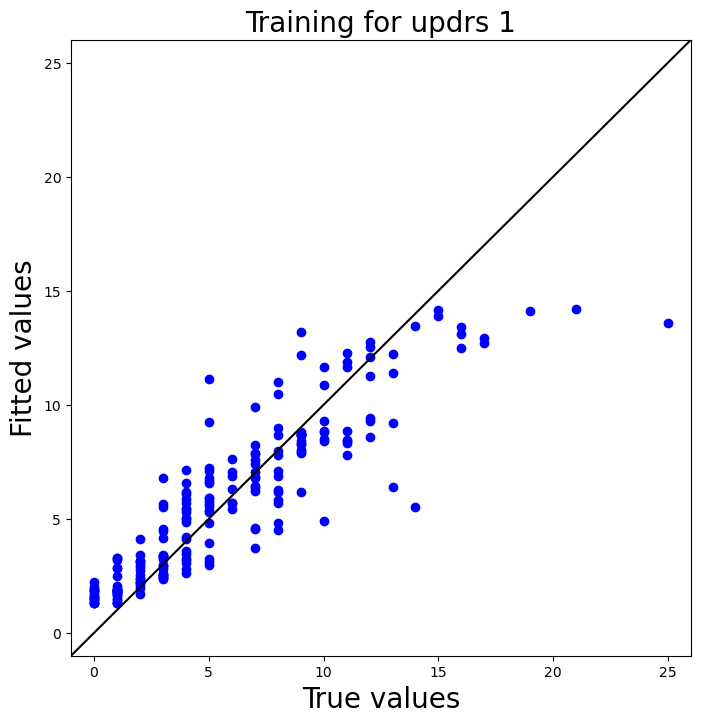

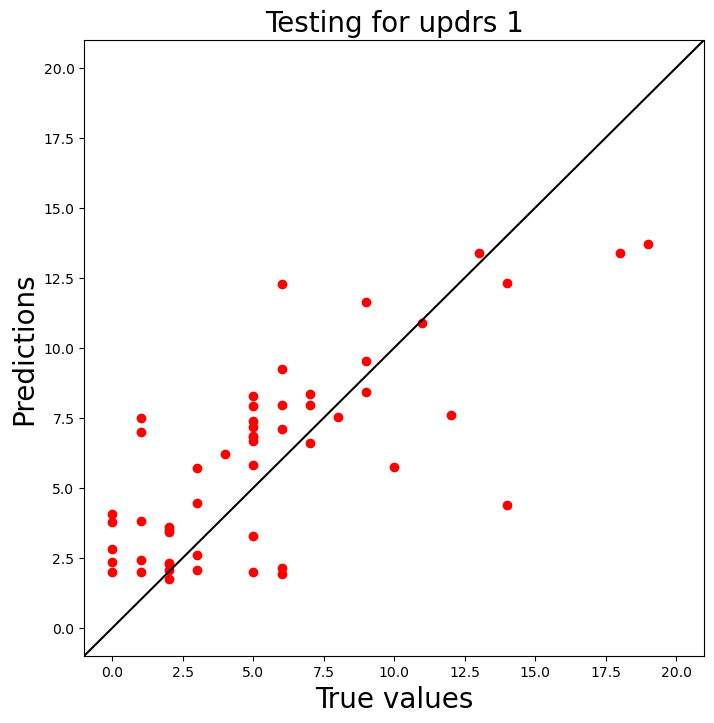

In [7]:
Y1_train_pred = clfr1.predict(X1_train)
plt.figure(figsize=(8,8))
plt.scatter(Y1_train, Y1_train_pred, c='b')
plt.plot([-1,26],[-1,26],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Fitted values', fontsize=20)
plt.title('Training for updrs 1', fontsize=20)
plt.xlim(-1,26)
plt.ylim(-1,26)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs1_train.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8,8))
plt.scatter(Y1_test,Y1_pred, c='red')
plt.plot([-1,21],[-1,21],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Testing for updrs 1', fontsize=20)
plt.xlim(-1,21)
plt.ylim(-1,21)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs1_test.png', dpi=300, bbox_inches='tight')


In [8]:
#model for updrs_2 regression
np.random.seed(0)
rfr2 = RandomForestRegressor()
clfr2 = RandomizedSearchCV(rfr2, tuned_parameters, cv=5, n_jobs=-1, verbose=2, random_state=0)
clfr2.fit(X2_train, Y2_train)
print('The best Random Forest hyperparameters for updrs_2 regression are:',clfr2.best_params_)
Y2_pred = clfr2.predict(X2_test)
print('R2 score for updrs_2 regression:', clfr2.score(X2_test, Y2_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best Random Forest hyperparameters for updrs_2 regression are: {'n_estimators': 200, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'squared_error'}
R2 score for updrs_2 regression: 0.679913486034833


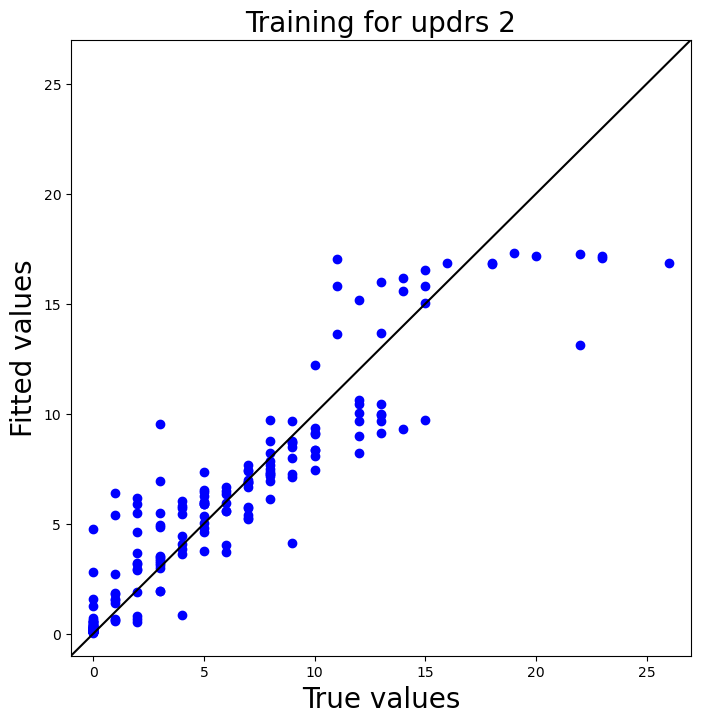

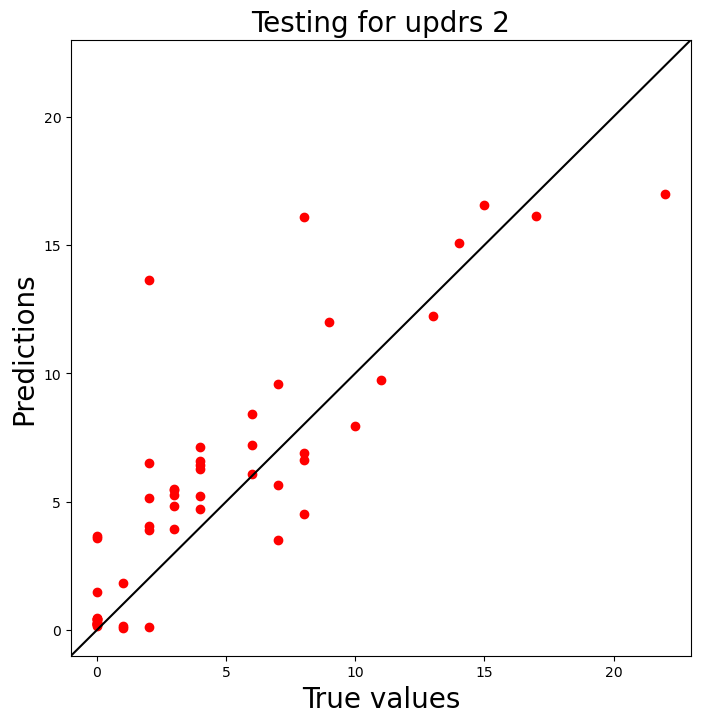

In [9]:
Y2_train_pred = clfr2.predict(X2_train)
plt.figure(figsize=(8,8))
plt.scatter(Y2_train, Y2_train_pred, c='b')
plt.plot([-1,27],[-1,27],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Fitted values', fontsize=20)
plt.title('Training for updrs 2', fontsize=20)
plt.xlim(-1,27)
plt.ylim(-1,27)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs2_train.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8,8))
plt.scatter(Y2_test,Y2_pred, c='red')
plt.plot([-1,23],[-1,23],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Testing for updrs 2', fontsize=20)
plt.xlim(-1,23)
plt.ylim(-1,23)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs2_test.png', dpi=300, bbox_inches='tight')



In [10]:
#model for updrs_3 regression
np.random.seed(0)
rfr3 = RandomForestRegressor(random_state = 0)
clfr3 = RandomizedSearchCV(rfr3, tuned_parameters, cv=5, n_jobs=-1, verbose=2)
clfr3.fit(X3_train, Y3_train)
print('The best Random Forest hyperparameters for updrs_3 regression are:',clfr3.best_params_)
Y3_pred = clfr3.predict(X3_test)
print('R2 score for updrs_3 regression:', clfr3.score(X3_test, Y3_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best Random Forest hyperparameters for updrs_3 regression are: {'n_estimators': 200, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 6, 'criterion': 'squared_error'}
R2 score for updrs_3 regression: 0.7570803489115185


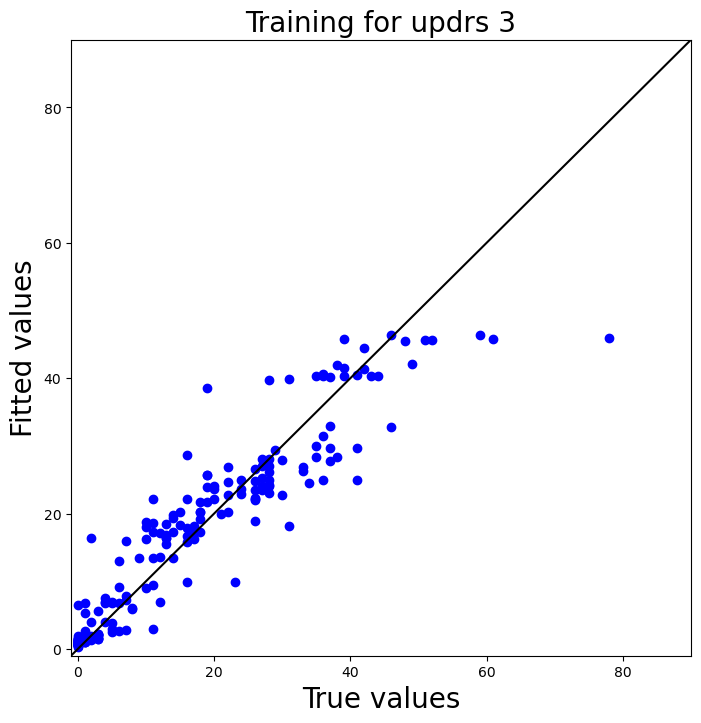

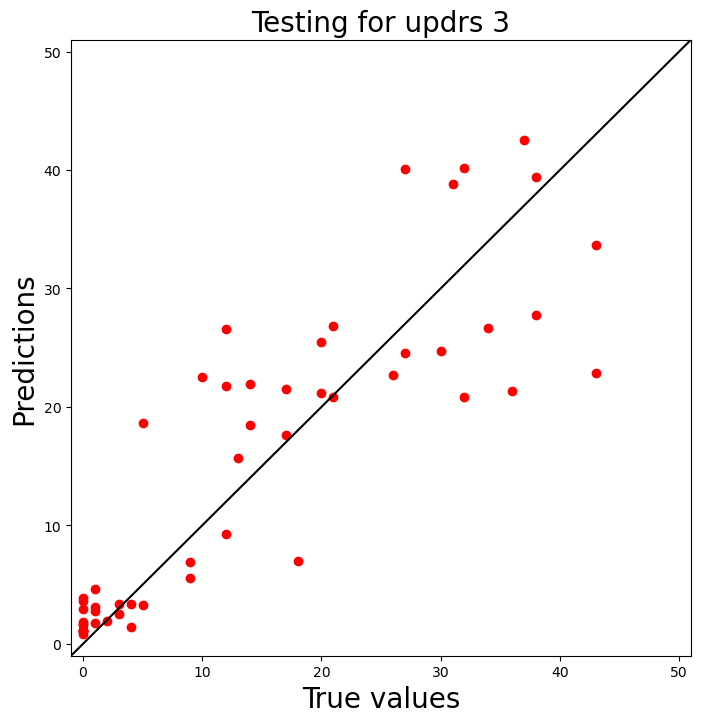

In [11]:
Y3_train_pred = clfr3.predict(X3_train)
plt.figure(figsize=(8,8))
plt.scatter(Y3_train, Y3_train_pred, c='b')
plt.plot([-1,90],[-1,90],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Fitted values', fontsize=20)
plt.title('Training for updrs 3', fontsize=20)
plt.xlim(-1,90)
plt.ylim(-1,90)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs3_train.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(8,8))
plt.scatter(Y3_test,Y3_pred, c='red')
plt.plot([-1,51],[-1,51],c='black')
plt.xlabel('True values', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Testing for updrs 3', fontsize=20)
plt.xlim(-1,51)
plt.ylim(-1,51)
plt.show()
#plt.savefig('/Users/zkl/Desktop/5291/project/fig/updrs3_test.png', dpi=300, bbox_inches='tight')

